In [0]:
# Importar os pacotes python
from google.colab import drive
import os
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Montar o acesso ao armazenamento de arquivos do google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Ver os dados da pasta '/content/drive/My Drive/Colab Notebooks/noverde/'
#!ls '/content/drive/My Drive/Colab Notebooks/'

installments_sample.json  payments_sample.parquet  Untitled0.ipynb
loans_sample.csv	  resultado.json


In [0]:
# Carregar o arquivo loans_sample.csv em um dataframe
v_Arquivo = "/content/drive/My Drive/Colab Notebooks/Noverde/loans_sample.csv"
Arq_Loans = pd.read_csv(v_Arquivo)

In [0]:
# Carregar o arquivo installments_sample.json e transformá-lo em dicionario
v_Arquivo = "/content/drive/My Drive/Colab Notebooks/Noverde/installments_sample.json"
Arquivo_json = open(v_Arquivo, 'r')
d_dados_json = json.load(Arquivo_json)  # Dicionario

# Separar, o arquivo json, em schema e dados em data frame separados
l_Schema_Install = d_dados_json['schema']
l_Data_Install = d_dados_json['data']

In [0]:
# Abrir o arquivo payments_sample.parquet e transformá-lo em dataframe
v_Arquivo = "/content/drive/My Drive/Colab Notebooks/Noverde/payments_sample.parquet"
Arquivo_Parquet = pd.read_parquet(v_Arquivo, engine='pyarrow')

In [0]:
# ROTINA PRINCIPAL PARA JUNTAR OS TRÊS ARQUIVOS (acima carregados) E TRANSFORMÁ-LO EM UMA ESTRUTURA PARA O HIVE
# Estrutura do Dataframe auxiliar (d_Metricas) para marcar a coluna Latency e Over30
colunas = [
    'installment_id',
    'dt_vencimento',
    'dt_pagamento',
    'latency',
    'over30'
]

file_data = []

# Criar a estrutura da tabela destino do Hive
d_Schema = '{"schema": {"fields":[{"name":"loan_id","type":"INT"},'
d_Schema = d_Schema + '{"name":"period","type":"INT"},'
d_Schema = d_Schema + '{"name":"accepted_at","type":"TIMESTAMP"},'
d_Schema = d_Schema + '{"name":"interest_rate","type":"DOUBLE"},'
d_Schema = d_Schema + '{"name":"installments","type":"MAP<INT, STRING>"},'
d_Schema = d_Schema + '{"name":"payments","type":"ARRAY<STRUCT<id: INT, payment_date: STRING, method: STRING, amount: DOUBLE>>"},'
d_Schema = d_Schema + '{"name":"metrics","type":"STRUCT<latency: ARRAY<BOOLEAN>, over30: ARRAY<BOOLEAN>>"}],'
d_Schema = d_Schema + '"ROW FORMAT SERDE":"org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe",'
d_Schema = d_Schema + '"WITH SERDEPROPERTIES":"(path=</content/drive/My Drive/Colab Notebooks/>)",'
d_Schema = d_Schema + '"STORED AS INPUTFORMAT":"org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat",'
d_Schema = d_Schema + '"OUTPUTFORMAT":"org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat",'
d_Schema = d_Schema + '"LOCATION":"/content/drive/My Drive/Colab Notebooks/"}'

# Ler o arquivo Loans_sample, installmente_sample.json e payments_sample.parquet e transformá-los em dicionário
str_Linha = '"data":['
n_Linha_loans = 1
n_Qtde = len(Arq_Loans)
for i in range(0, n_Qtde):
  if n_Linha_loans == 2:
    str_Linha_aux = ',{'
  else:
    n_Linha_loans = 2
    str_Linha_aux = '{'

  str_Linha_aux = str_Linha_aux + '"loan_id":' + str(Arq_Loans.loc[i, 'loan_id'])
  str_Linha_aux = str_Linha_aux + ',"period":' + str(Arq_Loans.loc[i, 'period'])
  str_Linha_aux = str_Linha_aux + ',"accepted_at":"' + Arq_Loans.loc[i, 'accepted_at'] + '"'
  str_Linha_aux = str_Linha_aux + ',"payday":' + str(Arq_Loans.loc[i, 'payday'])
  str_Linha_aux = str_Linha_aux + ',"interest_rate":' + str(Arq_Loans.loc[i, 'interest_rate'])

  n_loan_id = Arq_Loans.loc[i, 'loan_id']
  #print(n_loan_id)

  # Criar o dataframe de métricas
  d_Metricas = pd.DataFrame(columns=colunas)

  n_Linha_Install = 1
  # Verificar os registros de installments associados ao loan_id
  for data in l_Data_Install:
    if data['loan_id'] == n_loan_id:
      #print('passei installment')

      if n_Linha_Install == 2:
        str_Linha_aux = str_Linha_aux + ',{'
      else:
        n_Linha_Install = 2
        str_Linha_aux = str_Linha_aux + ',"installments": [{'
      #Fim if n_Linha_Install == 2

      str_Linha_aux = str_Linha_aux + '"installment_id":' + str(data['installment_id'])
      str_Linha_aux = str_Linha_aux + ',"loan_id":' + str(data['loan_id'])
      str_Linha_aux = str_Linha_aux + ',"number":' + str(data['number'])
      str_Linha_aux = str_Linha_aux + ',"due_date":"' + data['due_date'] + '"'
      str_Linha_aux = str_Linha_aux + ',"installment_value":' + str(data['installment_value'])

      str_Linha_aux = str_Linha_aux + '}'

      # Inserir no dataframe de metricas
      d_Metricas.loc[data['installment_id']] = [data['installment_id'], str(data['due_date']), '', "False", "False"]

  if n_Linha_Install == 2:
    str_Linha_aux = str_Linha_aux + ']'

  # Ler os registros de payment associados ao loan_id
  Arquivo_Parquet_aux = Arquivo_Parquet.loc[(Arquivo_Parquet['loan_id']) == n_loan_id]
  if len(Arquivo_Parquet_aux) > 0:
    n_Linha_parquet = 1
    Arquivo_Parquet_aux = Arquivo_Parquet_aux.reset_index()
    minimo = min(Arquivo_Parquet_aux.index)
    maximo = max(Arquivo_Parquet_aux.index)
    for parquet in range(minimo, maximo+1):
      #print('passei parquet')
      if n_Linha_parquet == 2:
        str_Linha_aux = str_Linha_aux + ',{'
      else:
        n_Linha_parquet = 2
        str_Linha_aux = str_Linha_aux + ',"payments": [{'
      #Fim if n_Linha_parquet == 2:

      #print(Arquivo_Parquet_aux.loc[parquet, 'installment_id'])
      str_Linha_aux = str_Linha_aux + '"loan_id":' + str(Arquivo_Parquet_aux.loc[parquet, 'loan_id'])
      str_Linha_aux = str_Linha_aux + ',"installment_id":' + str(Arquivo_Parquet_aux.loc[parquet, 'installment_id'])
      str_Linha_aux = str_Linha_aux + ',"payment_date":"' + str(Arquivo_Parquet_aux.loc[parquet, 'payment_date']) + '"'
      str_Linha_aux = str_Linha_aux + ',"payment_method":"' + Arquivo_Parquet_aux.loc[parquet, 'payment_method'] + '"'
      str_Linha_aux = str_Linha_aux + ',"paid_amount":' + str(Arquivo_Parquet_aux.loc[parquet, 'paid_amount'])

      str_Linha_aux = str_Linha_aux + '}'

      #Atualizar data de pagamento no dataframe metricas
      n_Indice = Arquivo_Parquet_aux.loc[parquet, 'installment_id']
      d_Metricas.loc[n_Indice]['dt_pagamento'] = str(Arquivo_Parquet_aux.loc[parquet, 'payment_date'])
    #Fim for parquet
  #Fim if len(Arquivo_Parquet_aux) > 0

  if n_Linha_parquet == 2:
    str_Linha_aux = str_Linha_aux + ']'

  # Verifica se teve loan no arquivo installment_sample.json
  if n_Linha_Install == 2:
    #Metrics
    d_Metricas = d_Metricas.reset_index()
    minimo = min(d_Metricas.index)
    maximo = max(d_Metricas.index)
    for n_Indice in range(minimo, maximo+1):
      #print('metricas')
      #Latencia
      if d_Metricas.loc[n_Indice]['dt_pagamento'] > d_Metricas.loc[n_Indice]['dt_vencimento']:
        d_Metricas.loc[n_Indice]['latency'] = "True"

      #Over30
      #Somente para quando não houver pagamento
      if d_Metricas.loc[n_Indice, 'dt_pagamento'] == "":
        now = datetime.now()
        str_Dt_Dia = str(str(now.year) + '-' + str(now.month) + '-' + str(now.day))
        dt_Dia = datetime.strptime(str_Dt_Dia, '%Y-%m-%d').date()
        dt_Vencimento = datetime.strptime(d_Metricas.loc[n_Indice]['dt_vencimento'][:10], '%Y-%m-%d').date()

        n_Qtde_dias = (dt_Dia - dt_Vencimento).days
        if n_Qtde_dias > 30:
          d_Metricas.loc[n_Indice]['over30'] = "True"
      #Fim if d_Metricas.loc
    #Fim for n_Indice

    # Montar a linha de metricas
    n_Linha_Metrics = 1
    str_Linha_Latency = ""
    str_Linha_Over30 = ""
    for n_Indice in range(minimo, maximo+1):
      if n_Linha_Metrics == 2:
        str_Linha_Latency = str_Linha_Latency + ','
        str_Linha_Over30 = str_Linha_Over30 + ','
      else:
        n_Linha_Metrics = 2
        str_Linha_Latency = '"latency":['
        str_Linha_Over30 = '"over30":['
      #Fim if n_Linha_Metrics == 2:

      str_Linha_Latency = str_Linha_Latency + '"' + d_Metricas.loc[n_Indice, 'latency'] + '"'
      str_Linha_Over30 = str_Linha_Over30 + '"' + d_Metricas.loc[n_Indice, 'over30'] + '"'
    #Fim for n_Indice

    str_Linha_Latency = str_Linha_Latency + ']'
    str_Linha_Over30 = str_Linha_Over30 + ']'

    str_Linha_aux = str_Linha_aux + ',"metrics": [{' + str_Linha_Latency + ',' + str_Linha_Over30 + '}]'

    str_Linha_aux = str_Linha_aux + '}'
    str_Linha = str_Linha + str_Linha_aux
  #Fim if n_Linha_Install == 2
#Fim do for principal (loan_sample)

# Juntar o schema da tabela com os dados
str_Linha = d_Schema + ',' + str_Linha + ']}'

str_Linha = '{"principal": [' + str_Linha + ']}'

# Fazer a identação no formato json
j_response = json.loads(str_Linha)

file_data.extend(j_response['principal'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
# Gravar o arquivo gerado no formato json para posteriormente ser carregado para o hive
v_Arquivo = "/content/drive/My Drive/Colab Notebooks/Noverde/resultado.json"
with open(v_Arquivo, "w") as arq_gravar:
    json.dump(file_data, arq_gravar, indent=4)

In [0]:
# ROTINA PRINCIPAL PARA JUNTAR OS TRÊS ARQUIVOS (acima carregados) E TRANSFORMÁ-LO EM UM DATASET

# Estrutura do dataframe de dados
colunas_princ = [
    'loan_id',
    'period',
    'accepted_at',
    'payday',
    'interest_rate',
    'installment_id',
    'number_portion',
    'due_date',
    'due_year_month',
    'installment_value',
    'portion',
    'payment_date',
    'payment_method',
    'payment_id',
    'paid_amount',
    'latency',
    'over30'
]

# Data Frame principal
df_Principal = pd.DataFrame(columns=colunas_princ)

# Data do dia
now = datetime.now()
str_Dt_Dia = str(str(now.year) + '-' + str(now.month) + '-' + str(now.day))
dt_Dia = datetime.strptime(str_Dt_Dia, '%Y-%m-%d').date()
#print(dt_Dia)

# Ler o arquivo Loans_sample, installmente_sample.json e payments_sample.parquet e transformá-los em dicionário
n_Qtde = len(Arq_Loans)
for loan in range(0, n_Qtde):

  n_loan_id = Arq_Loans.loc[loan, 'loan_id']

  # Verificar os registros de installments associados ao loan_id
  n_Portion = 0
  for data in l_Data_Install:
    if data['loan_id'] == n_loan_id:
      n_Portion = n_Portion + 1
      d_Due_Ano_Mes = data['due_date']
      d_Due_Ano_Mes = d_Due_Ano_Mes[:7]
      df_Principal.loc[data['installment_id']] = [Arq_Loans.loc[loan, 'loan_id'],
                                                  Arq_Loans.loc[loan, 'period'],
                                                  Arq_Loans.loc[loan, 'accepted_at'],
                                                  Arq_Loans.loc[loan, 'payday'],
                                                  Arq_Loans.loc[loan, 'interest_rate'],
                                                  data['installment_id'],
                                                  data['number'],
                                                  data['due_date'],
                                                  d_Due_Ano_Mes, 
                                                  data['installment_value'],
                                                  0,   #portion
                                                  '',  #payment_date
                                                  '',  #payment_method
                                                  '',  #payment_id
                                                  0.0, #paid_amount
                                                  "False", #latency
                                                  "False"] #over30
  #Fim for data

  # Atualizar a coluna portion
  if n_Portion > 0:
    for data in l_Data_Install:
      if data['loan_id'] == n_loan_id:
        df_Principal.loc[data['installment_id'],'portion'] = n_Portion

  #Fim if n_Portion > 0:

  # Ler os registros de payment associados ao loan_id
  Arquivo_Parquet_aux = Arquivo_Parquet.loc[(Arquivo_Parquet['loan_id']) == n_loan_id]

  if len(Arquivo_Parquet_aux) > 0:
    Arquivo_Parquet_aux = Arquivo_Parquet_aux.reset_index()
    minimo = min(Arquivo_Parquet_aux.index)
    maximo = max(Arquivo_Parquet_aux.index)
    for parquet in range(minimo, maximo+1):
      n_Indice = Arquivo_Parquet_aux.loc[parquet, 'installment_id']
      df_Principal.loc[n_Indice,'payment_date'] = str(Arquivo_Parquet_aux.loc[parquet, 'payment_date'])
      df_Principal.loc[n_Indice,'payment_method'] = str(Arquivo_Parquet_aux.loc[parquet, 'payment_method'])
      df_Principal.loc[n_Indice,'payment_id'] = str(Arquivo_Parquet_aux.loc[parquet, 'payment_id'])
      df_Principal.loc[n_Indice,'paid_amount'] = Arquivo_Parquet_aux.loc[parquet, 'paid_amount']

    #Fim for parquet
  #Fim if len(Arquivo_Parquet_aux)
#Fim for loan

# Ajustar os valores de latency e over30
for n_Indice, row in df_Principal.iterrows():

  #Latencia
  if df_Principal.loc[n_Indice]['payment_date'] > df_Principal.loc[n_Indice]['due_date']:
    df_Principal.loc[n_Indice,'latency'] = "True"

  #Over30
  #Somente para quando não houver pagamento
  if df_Principal.loc[n_Indice, 'payment_date'] == "":
    dt_due_date = datetime.strptime(df_Principal.loc[n_Indice]['due_date'][:10], '%Y-%m-%d').date()

    n_Qtde_dias = (dt_Dia - dt_due_date).days
    if n_Qtde_dias > 30:
      df_Principal.loc[n_Indice,'over30'] = "True"
#Fim for n_Indice, row

#Converter coluna de data para tipo date
df_Principal['due_date'] = pd.to_datetime(df_Principal['due_date'])
df_Principal['payment_date'] = pd.to_datetime(df_Principal['payment_date'])


In [0]:
# CALCULAR O PERCENTUAL DE PAGAMENTO SOBRE OS VENCIMENTOS POR MES/ANO
# Fazer copia do dataframe principal
df_Principal_1 = df_Principal.copy()

# Adicionar colunas de mês e ano para due e payment
df_Principal_1['due_year'] = df_Principal_1['due_date'].dt.year
df_Principal_1['due_month'] = df_Principal_1['due_date'].dt.month
df_Principal_1['payment_year'] = df_Principal_1['payment_date'].dt.year
df_Principal_1['payment_month'] = df_Principal_1['payment_date'].dt.month

# Criar dataframes de due e payment
df_Principal_Due = df_Principal_1.loc[:, ['installment_value', 'due_year', 'due_month','due_year_month']]
df_Principal_Pay = df_Principal_1.loc[:, ['paid_amount', 'payment_year', 'payment_month']]
df_Principal_Pay = df_Principal_Pay[(df_Principal_Pay.paid_amount != 0)] # excluir os valores zerados

# Renomear as colunas
df_Principal_Due = df_Principal_Due.rename(columns={'due_year': 'year', 'due_month': 'month', 'due_year_month': 'year_month'})
df_Principal_Pay = df_Principal_Pay.rename(columns={'payment_year': 'year', 'payment_month': 'month'})

# Trocar o índice
df_Principal_Due = df_Principal_Due.set_index(['year', 'month'])
df_Principal_Pay = df_Principal_Pay.set_index(['year', 'month'])

# Agrupar pelo índice
df_Principal_Due = df_Principal_Due.groupby(level = ['year', 'month'])
df_Principal_Pay = df_Principal_Pay.groupby(level = ['year', 'month'])

# Somar os valores
df_Principal_Due_Sum = df_Principal_Due.sum()
df_Principal_Pay_Sum = df_Principal_Pay.sum()

# Resetar o índice
df_Principal_Pay_Sum = df_Principal_Pay_Sum.reset_index()
df_Principal_Due_Sum = df_Principal_Due_Sum.reset_index()

# Unir os dataframes (merge)
df_Principal_Sum = pd.merge(df_Principal_Pay_Sum, df_Principal_Due_Sum, how='outer')

# Zerando os valores NaN
df_Principal_Sum.update(df_Principal_Sum['paid_amount'].fillna(0))
df_Principal_Sum.update(df_Principal_Sum['installment_value'].fillna(0))

# Calcular o percentual (ratio) de pagamentos
df_Principal_Sum['ratio'] = df_Principal_Sum['paid_amount'] / df_Principal_Sum['installment_value'] * 100

df_Principal_Sum

,year,month,paid_amount,installment_value,ratio
0,2017.0,4.0,650.97,0.00,inf
1,2017.0,5.0,59249.01,40833.09,145.100481
2,2017.0,6.0,190729.96,188638.91,101.108493
3,2017.0,7.0,245871.47,351804.53,69.888659
4,2017.0,8.0,240664.31,352574.86,68.259067
5,2017.0,9.0,236209.18,352574.86,66.995469
6,2017.0,10.0,224983.51,352574.86,63.811558
7,2017.0,11.0,232571.17,349985.87,66.451588
8,2017.0,12.0,208789.67,337129.27,61.931635
9,2018.0,1.0,202668.63,324500.99,62.455474


In [0]:
# CALCULAR A MEDIA DE PERIOD E DE INTEREST_RATE E A MAIOR FREQUÊNCIA DE PAYDAY
# Fazer copia do dataframe principal
df_Principal_2 = df_Principal.copy()

# Adicionar colunas de mês e ano para due
df_Principal_2['year'] = df_Principal_2['due_date'].dt.year
df_Principal_2['month'] = df_Principal_2['due_date'].dt.month

# Criar dataframes de due e payment
df_Principal_Avg = df_Principal_2.loc[:, ['period', 'interest_rate', 'year', 'month']]
df_Principal_Fre = df_Principal_2.loc[:, ['payday', 'year', 'month']]

# Transformar o tipo das colunas para integer
df_Principal_Avg['period'] = pd.to_numeric(df_Principal_Avg['period'])
df_Principal_Fre['payday'] = pd.to_numeric(df_Principal_Fre['payday'])

# Trocar o índice
df_Principal_Avg = df_Principal_Avg.set_index(['year', 'month'])

# Agrupar pelo índice
df_Principal_Avg = df_Principal_Avg.groupby(level = ['year', 'month'])

# Somar os valores
df_Principal_Avg = df_Principal_Avg.mean()
df_Principal_Avg = df_Principal_Avg.reset_index()

#--------------------------------------------------------------------------
# Verificar o maior payday por mês/ano
df_Principal_Fre = df_Principal_Fre.sort_values(['year', 'month'])
df_Principal_Fre = df_Principal_Fre.reset_index()

colunas_aux = [
    'year',
    'month',
    'payday'
]

# Data Frame principal
df_Principal_Fre2 = pd.DataFrame(columns=colunas_aux)
qtde = len(df_Principal_Fre)
Ano_Ant = 0 
Mes_Ant = 0
for conta in range(0, qtde):
  if df_Principal_Fre.loc[conta, 'year'] != Ano_Ant or df_Principal_Fre.loc[conta, 'month'] != Mes_Ant:
    Ano_Ant = df_Principal_Fre.loc[conta, 'year']
    Mes_Ant = df_Principal_Fre.loc[conta, 'month']
  
    df1 = df_Principal_Fre.loc[(df_Principal_Fre['year'] == Ano_Ant) & (df_Principal_Fre['month'] == Mes_Ant)]
    df1 = df1.loc[:, ['payday']]
    df1 = df1.apply(pd.value_counts)

    for n_Indice, row in df1.iterrows():
      n_Qt_Maior = df1.loc[n_Indice]['payday']
      n_Qt_Maior = n_Indice

      break

    df_Principal_Fre2.loc[conta] = [df_Principal_Fre.loc[conta, 'year'],
                                            df_Principal_Fre.loc[conta, 'month'],
                                            n_Qt_Maior]
df_Principal_Fre2 = df_Principal_Fre2.reset_index()
df_Principal_Fre2 = df_Principal_Fre2.drop(columns=['index'])

# Unir os dataframes (merge)
df_Principal_Avg = pd.merge(df_Principal_Avg, df_Principal_Fre2, how='outer')
df_Principal_Avg.columns = ['year', 'month', 'avg_period', 'avg_interest_rate', 'freq_payday']
df_Principal_Avg

,year,month,avg_period,avg_interest_rate,freq_payday
0,2017,5,11.494737,6.841789,15
1,2017,6,11.323944,6.998146,15
2,2017,7,11.400778,6.979663,15
3,2017,8,11.402329,6.981138,25
4,2017,9,11.402329,6.981138,25
5,2017,10,11.402329,6.981138,25
6,2017,11,11.430429,6.987048,25
7,2017,12,11.635628,6.980675,25
8,2018,1,11.791956,6.973287,15
9,2018,2,11.823282,6.979383,25


In [0]:
# CALCULAR A QTDE DE LOAN E A MAIOR FREQUENCIA DE PAYDAY
# Fazer copia do dataframe principal
df_Principal_3 = df_Principal.copy()

# Criar dataframes de due e payment
df_Principal_Loan = df_Principal_3.loc[:, ['period', 'interest_rate', 'loan_id']]
df_Principal_Fre  = df_Principal_3.loc[:, ['period', 'interest_rate', 'payday']]

# Transformar o tipo das colunas para integer
df_Principal_Loan['loan_id'] = pd.to_numeric(df_Principal_Loan['loan_id'])
df_Principal_Fre['payday'] = pd.to_numeric(df_Principal_Fre['payday'])

# Trocar o índice
#df_Principal_Avg = df_Principal_Avg.set_index(['year', 'month'])
#df_Principal_Fre = df_Principal_Fre.set_index(['year', 'month'])

# Agrupar pelo índice
#df_Principal_Avg = df_Principal_Avg.groupby(level = ['year', 'month'])
#df_Principal_Fre = df_Principal_Fre.groupby(level = ['year', 'month'])

# Somar os valores
#df_Principal_Avg = df_Principal_Avg.mean()
#df_Principal_Avg = df_Principal_Avg.reset_index()

#--------------------------------------------------------------------------
# Apurar a quantidade de loan por period e interest_rate
df_Principal_Loan = df_Principal_Loan.sort_values(['period', 'interest_rate'])
df_Principal_Loan = df_Principal_Loan.reset_index()

colunas_aux = [
    'period',
    'interest_rate',
    'loan_id'
]

# Data Frame principal
df_Principal_Loan2 = pd.DataFrame(columns=colunas_aux)
df_Principal_Loan = df_Principal_Loan.drop(columns=['index'])
df_Principal_Loan = df_Principal_Loan.drop_duplicates()
df_Principal_Loan = df_Principal_Loan.reset_index()
#df_Principal_Loan = df_Principal_Loan2.drop(columns=['index'])
df_Principal_Loan

n_Qtde = len(df_Principal_Loan)
Period_Ant = 0 
Interest_Ant = 0

for conta in range(0, n_Qtde):
  if df_Principal_Loan.loc[conta, 'period'] != Period_Ant or df_Principal_Loan.loc[conta, 'interest_rate'] != Interest_Ant:
    Period_Ant   = df_Principal_Loan.loc[conta, 'period']
    Interest_Ant = df_Principal_Loan.loc[conta, 'interest_rate']
  
    df1 = df_Principal_Loan.loc[(df_Principal_Loan['period'] == Period_Ant) & (df_Principal_Loan['interest_rate'] == Interest_Ant)]
    df1 = df1.loc[:, ['loan_id']]
    df1 = df1.apply(pd.value_counts)
    n_Qtde_Loan = len(df1)

    df_Principal_Loan2.loc[conta] = [int(df_Principal_Loan.loc[conta, 'period']),
                                     df_Principal_Loan.loc[conta, 'interest_rate'],
                                     int(n_Qtde_Loan)]

df_Principal_Loan2 = df_Principal_Loan2.reset_index()
df_Principal_Loan2 = df_Principal_Loan2.drop(columns=['index'])

#--------------------------------------------------------------------------
# Verificar o maior payday por mês/ano
df_Principal_Fre = df_Principal_Fre.sort_values(['period', 'interest_rate'])
df_Principal_Fre = df_Principal_Fre.reset_index()

colunas_aux = [
    'period',
    'interest_rate',
    'payday'
]

# Data Frame principal
df_Principal_Fre2 = pd.DataFrame(columns=colunas_aux)
qtde = len(df_Principal_Fre)
Period_Ant   = 0 
Interest_Ant = 0

for conta in range(0, qtde):
  if df_Principal_Fre.loc[conta, 'period'] != Period_Ant or df_Principal_Fre.loc[conta, 'interest_rate'] != Interest_Ant:
    Period_Ant   = df_Principal_Fre.loc[conta, 'period']
    Interest_Ant = df_Principal_Fre.loc[conta, 'interest_rate']

    df1 = df_Principal_Fre.loc[(df_Principal_Fre['period'] == Period_Ant) & (df_Principal_Fre['interest_rate'] == Interest_Ant)]
    df1 = df1.loc[:, ['payday']]
    df1 = df1.apply(pd.value_counts)

    for n_Indice, row in df1.iterrows():
      n_Qt_Maior = df1.loc[n_Indice]['payday']
      n_Qt_Maior = n_Indice

      break

    df_Principal_Fre2.loc[conta] = [df_Principal_Fre.loc[conta, 'period'],
                                    df_Principal_Fre.loc[conta, 'interest_rate'],
                                    n_Qt_Maior]
df_Principal_Fre2 = df_Principal_Fre2.reset_index()
df_Principal_Fre2 = df_Principal_Fre2.drop(columns=['index'])

# Criar coluna avg_interest_rate
df_Principal_Loan2['avg_interest_rate'] = df_Principal_Loan2['interest_rate']

# Unir os dataframes (merge)
df_Principal_Loan = pd.merge(df_Principal_Loan2, df_Principal_Fre2, how='outer')
df_Principal_Loan.columns = ['period', 'interest_rate', 'count_loan_id', 'avg_interest_rate', 'freq_payday']
df_Principal_Loan

,period,interest_rate,count_loan_id,avg_interest_rate,freq_payday
0,6.0,3.68,10.0,3.68,15.0
1,6.0,5.74,2.0,5.74,15.0
2,6.0,8.01,40.0,8.01,25.0
3,9.0,3.25,5.0,3.25,15.0
4,9.0,5.23,1.0,5.23,25.0
5,9.0,7.49,44.0,7.49,25.0
6,12.0,3.12,83.0,3.12,25.0
7,12.0,5.15,9.0,5.15,15.0
8,12.0,7.49,1.0,7.49,15.0
9,12.0,7.55,580.0,7.55,15.0


In [0]:
# CALCULAR A QTDE DE CONTRATOS MATURED E OVER30
# Fazer copia do dataframe principal
df_Principal_4 = df_Principal.copy()

colunas_aux = [
    'loan_id',
    'flag_loan_id',
    'due_date',
    'over30',
    'matured_portfolio'
]

# Data Frame principal
df_Principal_Aux = pd.DataFrame(columns=colunas_aux)

df_Principal_4 = df_Principal_4.sort_values(['loan_id', 'number_portion'])
df_Principal_4 = df_Principal_4.reset_index()
df_Principal_4 = df_Principal_4.drop(columns=['index'])
n_Qtde = len(df_Principal_4)

# Data do dia
now = datetime.now()
str_Dt_Dia = str(str(now.year) + '-' + str(now.month) + '-' + str(now.day))
dt_Dia = datetime.strptime(str_Dt_Dia, '%Y-%m-%d').date()
#print(dt_Dia)

n_Loan_Ant = 0
for n_Indice in range(0, n_Qtde):
  if df_Principal_4.loc[n_Indice, 'number_portion'] == 1:
    v_Matured = 0
    dt_due_date = str(df_Principal_4.loc[n_Indice]['due_date']) #datetime.strptime(df_Principal_4.loc[n_Indice]['due_date'][:10], '%Y-%m-%d').date()
    dt_due_date = datetime.strptime(dt_due_date[:10], '%Y-%m-%d').date()

    n_Qtde_dias = (dt_Dia - dt_due_date).days
    if n_Qtde_dias > 30:
      v_Matured = 1

    df_Principal_Aux.loc[n_Indice] = [df_Principal_4.loc[n_Indice, 'loan_id'],
                                      1, #flag_loan_id
                                      df_Principal_4.loc[n_Indice, 'due_date'],
                                      0,  #over30
                                      v_Matured]  #matured_portfolio
    n_Indice_aux = n_Indice
  #Fim if

  if df_Principal_4.loc[n_Indice, 'over30'] == "True":
    df_Principal_Aux.loc[n_Indice_aux,'over30'] = 1
#Fim For

n_Qt_Loan    = df_Principal_Aux['flag_loan_id'].sum()
n_Qt_Over30  = df_Principal_Aux['over30'].sum()
n_Qt_Matured = df_Principal_Aux['matured_portfolio'].sum()

n_Ratio = n_Qt_Over30 / n_Qt_Matured * 100

colunas_aux = [
    'total_portfolio',
    'matured_portfolio',
    'over30_true',
    'ratio'
]

# Data Frame para relatório
df_Rel = pd.DataFrame(columns=colunas_aux)

df_Rel.loc[0] = [n_Qt_Loan,
                 n_Qt_Over30,
                 n_Qt_Matured,
                 n_Ratio]

df_Rel
df_Rel.loc[:, ['total_portfolio', 'matured_portfolio', 'over30_true','ratio']]


,total_portfolio,matured_portfolio,over30_true,ratio
0,775.0,738.0,775.0,95.225806


In [0]:
# GRAFICOS

Text(0.5, 0, 'Year Month Due')

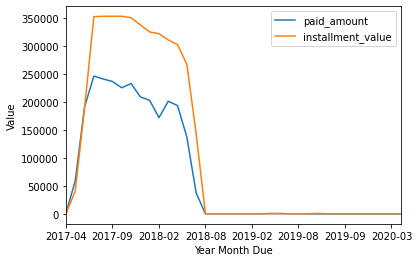

In [0]:
# EXIBIR A RELAÇÃO ENTRE PAID_AMOUNT X INSTALLMENT_VALUE POR MÊS DUE_DATE 
# Montar dataset para o grafico de linha
qtde = len(df_Principal_Sum)

df_Grafico = df_Principal_Sum.copy()

for n_Indice in range(0, qtde):
  Ano = df_Grafico.loc[n_Indice, 'year']
  Mes = df_Grafico.loc[n_Indice, 'month']
  if Mes < 10:
    v_Year_Month = str(int(Ano)) + '-0' + str(int(Mes))
  else:
    v_Year_Month = str(int(Ano)) + '-' + str(int(Mes))
  #print(v_Year_Month)
  df_Grafico.loc[n_Indice,'year_month'] = v_Year_Month

df_Grafico = df_Grafico.set_index(['year_month'])
df_Grafico = df_Grafico.drop(columns=['year','month','ratio'])

#df_Grafico
df_Grafico.plot()
plt.ylabel("Value")
plt.xlabel("Year Month Due")

Text(0.5, 0, 'Year Month Due')

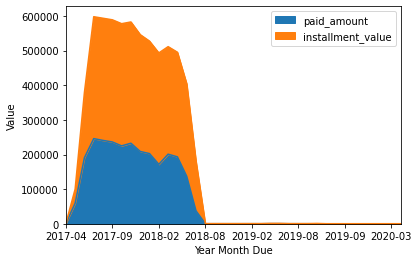

In [0]:
df_Grafico.plot(kind = 'area')
plt.ylabel("Value")
plt.xlabel("Year Month Due")

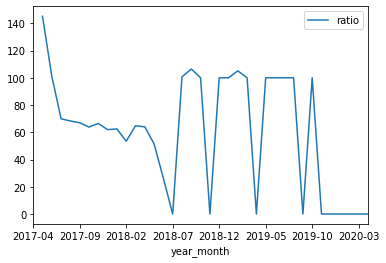

In [0]:
# EXIBIR A % RECEBIDA EM RELAÇÃO AOS VALORES A RECEBER ATRAVÉS DOS MESES 
# Montar dataset para o grafico de linha
qtde = len(df_Principal_Sum)

df_Grafico1 = df_Principal_Sum.copy()

for n_Indice in range(0, qtde):
  Ano = df_Grafico1.loc[n_Indice, 'year']
  Mes = df_Grafico1.loc[n_Indice, 'month']
  if Mes < 10:
    v_Year_Month = str(int(Ano)) + '-0' + str(int(Mes))
  else:
    v_Year_Month = str(int(Ano)) + '-' + str(int(Mes))
  #print(v_Year_Month)
  df_Grafico1.loc[n_Indice,'year_month'] = v_Year_Month

df_Grafico1 = df_Grafico1.set_index(['year_month'])
df_Grafico1 = df_Grafico1.drop(columns=['year','month','paid_amount','installment_value'])
df_Grafico1 = df_Grafico1.sort_values(['year_month'])

#df_Grafico1
df_Grafico1.plot()